# Quantum Coherence

This notebook will introduce the concept of quantum coherence as a resource, giving a few examples of metrics and simple applications.

In [193]:
# importing qiskit
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.tools.visualization import plot_histogram
# importing other tools
import numpy as np
import matplotlib.pyplot as plt

from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.random import random_circuit

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


# Other utilities


provider = IBMQ.load_account()
%matplotlib inline


ibmqfactory.load_account:WARNING:2020-08-14 17:14:28,683: Credentials are already in use. The existing account in the session will be replaced.


## Coherence

Coherence originates from the mathematics of waves, quantifying correlation between properties of a single or multiple wave functions. This correlation manifests as constructive or destructive interference when waves are temporally or spatially superposed. As an example, one can think of a plucked guitar string, where reflections of the generated wave off of the ends of the string constructively interact to form a standing wave that rings at a particular frequency. This is a coherent state.

Modern quantum mechanics is rooted in wave theory; we can consider quantum states to be waves. Similar to the above, consider a qubit in the $|0\rangle$ state. We can "pluck" this qubit by applying a unitary operation, say the Hadamard opeation, giving $\frac{|0\rangle + |1\rangle}{\sqrt2}$, the equal sum of two "incident waves" and said to be the maximally coherent state. 

Now say we have two qubits in the $|01\rangle$ state. Applying a Hadamard to qubit 0, followed by a controlled-Z operation with qubit 0 as the control and 1 as the target gives $\frac{|01\rangle - |11\rangle}{\sqrt2}$. Applying a Hadamard to 0 again intermediately creates the superposition of two "waves" $\frac{|01\rangle + |11\rangle}{2} - \frac{|01\rangle - |11\rangle}{2}$. These destructively interfere in their $|01\rangle$ component, leaving only the $|11\rangle$ state. This is a usual procedure in quantum algorithms; we try to manipulate the interference of the different components to yield solutions to computational problems.

As coherence is something we exploit, and is limited in non-ideal cases, recent literature has made attempts at quantifying coherence as a resource in quantum systems, similar to what has been done for entanglement in more established quantum information theory. This effort has developed measures of coherence, a few of which we will give a description.

### Relative Entropy of Coherence

A measure of coherence that is common in literature is the relative entropy of coherence. Defining the dephasing operation $\Delta[\rho]$ as the function that returns the diagonal part of the input density matrix, the formula for this measure of coherence is:

\begin{equation*}
C_{r}(\rho) = S(\Delta[\rho]) - S(\rho)
\end{equation*}

So we can easily define this from our entropy function in the previous notebook.


In [18]:
def C_r(state):
    return entropy(np.diag(np.diag(state))) - entropy(state)
    

This is the relative entropy between the fully incoherent version of the matrix and itself, which is something like seeing the effect of the off diagonal elements on the information content. For a pure state, the second term disappears by definition of von Neumann entropy. On the other hand, if the state is fully decohered (diagonal), this difference will be zero. So there is an intuitive aspect to this formula, as we know that the usual T2 coherence time is associated with the off-diagonal elements of a state's density matrix. We also get the convenient property of being additive under tensor products:

\begin{equation*}
C_{r}(\rho \otimes \sigma) = C_{r}(\rho) + C_{r}(\sigma)
\end{equation*}

This gives a useful quantifier; for example, say we Hadamard a whole n-qubit register, obtaining the maximally coherent state for its Hilbert space. This state is separable, therefore from the properties above we have:

\begin{equation*}
C_{r}(\bigotimes_{i=0}^{n-1} \rho_{i}) = \sum_{i}^{n-1} C_{r}(\rho_{i}) = \sum_{i=0}^{n-1} 1 = n
\end{equation*}

We can interpret this as the maximally coherent state of a qubit sets the benchmark for one fully coherent bit (sometimes called cobit) of information.

### L1-Norm of Coherence

Another quantifier of coherence is the l1-norm of coherence. This has a simpler formula than relative entropy of coherence:

\begin{equation*}
C_{l1}(\rho) = \sum_{i \neq j} |\rho_{ij}|
\end{equation*}

which is the sum of the absolute values of all of the off-diagonal elements, retaining the intuition regarding how decoherence occurs, and being easier to compute. 

In [1]:
def C_l1(state):
    abs_state = np.abs(state)
    return np.sum(abs_state) - np.trace(abs_state) 

This value obviously does not have the cobit interpretation, but has a similarly useful one. As the L1 norm of coherence is bounded above by $2^{n} - 1$, we can say that it gives roughly how much of the Hilbert space are in superposition, having a more fine grained value. We can compare the maximum values between this and the relative entropy of coherence for increasing system size.

In [66]:
relative = []
l1 = []
n = 10
nqubits = [i+1 for i in range(n)]

for i in nqubits:
    
    q = QuantumRegister(i)
    circ = QuantumCircuit(q)
    
    circ.h([j for j in range(len(q))])

    job = qiskit.execute(circ, Aer.get_backend('statevector_simulator'))
    psi = job.result().get_statevector(circ)
    psi.shape = (2**circ.num_qubits,1)
    rho = psi.dot(psi.conj().T)
        
    relative += [C_r(rho)]
    l1 += [C_l1(rho)]

    

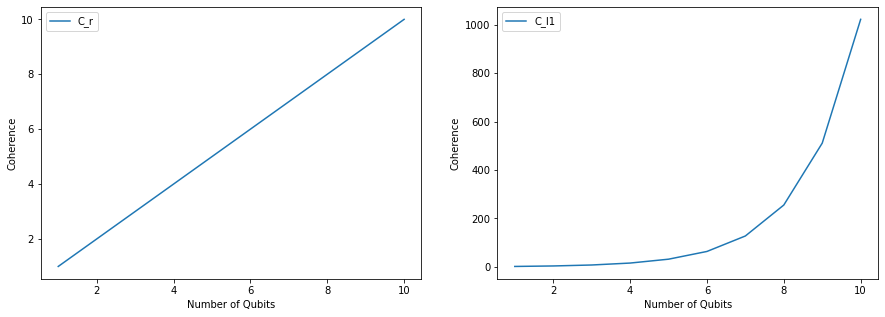

In [87]:
coherences = [relative,l1]
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(15,5))

for i in range(len(coherences)):
    axplt = axes[i]
    if i == 0:
        axplt.plot(qubits,coherences[i],label='C_r')
    else:
        axes[i].plot(qubits,coherences[i],label='C_l1')
    
    axplt.set_xlabel('Number of Qubits')
    axplt.set_ylabel('Coherence')
    axplt.legend()
    

Looking at the plots, the relative entropy of coherence has a more straight-forward interpretation. Also, in terms of how these might be computed at scale, exponential values of from the l1-norm may be excessive.

### Simulation of a Real Device

Since we have quantifiers of quantum coherence, a fun exercise would be to compare the degradation of these values with circuit depth on a simulated device, and comparing to the actual coherence times. Let's bring in a noise model based off of the Vigo machine.

In [88]:
# Build noise model from backend properties

backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

nqubits = len(backend.properties()._qubits)


Next, we'll generate circuits that Hadamard each qubit individually, apply a varying number of identity gates, and perform tomography measurements. For simplicity, we'll only use relative entropy of coherence as our measure, since we'll only have single qubit density matrices.

In [92]:
result_matrices = []

depths = [1,5,10,50,100,500]
results = {zz}
for q in range(nqubits):
    results[q] = []
    

for i in range(nqubits):
    for depth in depths:
        
        circ = QuantumCircuit(nqubits,nqubits)

        circ.h(i)
        for _ in range(depth): 
            circ.i(i)
            circ.barrier()
  

        # Generate the state tomography circuits.
        qst_qc = state_tomography_circuits(circ,circ.qubits[i])
        job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'),shots=8192
                            ,coupling_map=coupling_map
                            ,basis_gates=basis_gates
                            ,noise_model=noise_model
                    )

        tomo_qc = StateTomographyFitter(job.result(), qst_qc)
        rho = tomo_qc.fit()
        results[i] += [C_r(rho)]



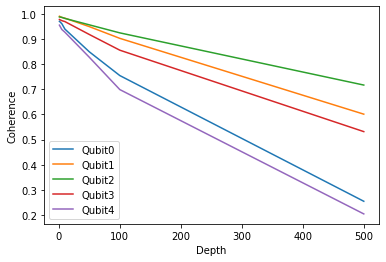

In [98]:
for i in range(nqubits):
    plt.plot(depths,results[i],label='Qubit' + str(i))
plt.xlabel('Depth')
plt.ylabel('Coherence')
plt.legend()

In [102]:
T2 = []

for i in range(nqubits):
    T2 += [backend.properties()._qubits[i]['T2'][0]]
    print('Qubit'+str(i)+' T2 = ', T2[i])


Qubit0 T2 =  1.3281374697173205e-05
Qubit1 T2 =  4.735013720269316e-05
Qubit2 T2 =  0.00012324151451574772
Qubit3 T2 =  0.00014637737248114537
Qubit4 T2 =  2.4590636341228415e-05


The model is a little off when considering this metric, however it generally shows that qubits 1, 2, and 3 perform better than 0 and 4. Qubit 4 seems to be on track to reaching full decoherence with a bit longer depth. With a quick calculation, we can get an estimate of the T2 time based on the id gate length information for the qubit.

In [148]:
depth = 600
circ = QuantumCircuit(nqubits,nqubits)

circ.h(4)
for _ in range(depth): 
    circ.i(4)
    circ.barrier()


# Generate the state tomography circuits.
qst_qc = state_tomography_circuits(circ,circ.qubits[4])
job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'),shots=8192
                    ,coupling_map=coupling_map
                    ,basis_gates=basis_gates
                    ,noise_model=noise_model
            )

tomo_qc = StateTomographyFitter(job.result(), qst_qc)
rho = tomo_qc.fit()
q4_coherence = C_r(rho)

In [149]:
q4_coherence

0.01536095810602367

Close enough to zero, lets pull the id gate length from the properties and multiply by the depth to get an estimate.

In [166]:
id4_length = backend.properties().gate_length('id',4)
q4_T2_est = id4_length * depth
q4_T2_est

2.1333333333333338e-05

In [167]:
pcterror = np.abs(T2[4] - q4_T2_est)/T2[4] * 100
pcterror

13.246111091618706

Not bad for a very rough estimate based off of the simulator, try it with the various real devices!

### Application in quantum algorithms

In [168]:
def generateBVcircuit(nQubits,a):
    # qubits for querying the oracle and finding the hidden integer
    qr = QuantumRegister(nQubits)

    circuitName = "BernsteinVazirani"
    bvCircuit = QuantumCircuit(qr)

    # Apply Hadamard gates before querying the oracle
    for i in range(nQubits):
        bvCircuit.h(qr[i])

    # Apply barrier so that it is not optimized by the compiler
    bvCircuit.barrier()

    # Apply the inner-product oracle
    for i in range(nQubits):
        if (a & (1 << i)):
            bvCircuit.z(qr[i])
        else:
            bvCircuit.i(qr[i])

    # Apply barrier 
    bvCircuit.barrier()

    #Apply Hadamard gates after querying the oracle
    for i in range(nQubits):
        bvCircuit.h(qr[i])
        
    return bvCircuit

def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    """Circuit that computes the black-box function from f_in to f_out.

    Create a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
# -- end function

def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function

def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(f_in[j])
# -- end function
"""
Grover search implemented in Qiskit.

This module contains the code necessary to run Grover search on 3
qubits, both with a simulator and with a real quantum computing
device. This code is the companion for the paper
"An introduction to quantum computing, without the physics",
Giacomo Nannicini, https://arxiv.org/abs/1708.03684. 
"""

def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function

# Make a quantum program for the n-bit Grover search.
n = 3

def generateGroverCircuit(n):
    # Exactly-1 3-SAT formula to be satisfied, in conjunctive
    # normal form. We represent literals with integers, positive or
    # negative, to indicate a Boolean variable or its negation.
    exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

    # Define three quantum registers: 'f_in' is the search space (input
    # to the function f), 'f_out' is bit used for the output of function
    # f, aux are the auxiliary bits used by f to perform its
    # computation.
    f_in = QuantumRegister(n)
    f_out = QuantumRegister(1)
    aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

    # Define classical register for algorithm result
    # ans = ClassicalRegister(n)

    # Define quantum circuit with above registers
    grover = QuantumCircuit()
    grover.add_register(f_in)
    grover.add_register(f_out)
    grover.add_register(aux)
    # grover.add_register(ans)

    input_state(grover, f_in, f_out, n)
    T = 2
    for t in range(T):
        # Apply T full iterations
        black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
        inversion_about_average(grover, f_in, n)
        
    return grover

def generateSimonCircuit(s):
    
    n = len(s)
    # Step 1
    # Creating registers
    # qubits for querying the oracle and recording its output
    qr = QuantumRegister(2*n)
    # for recording the measurement on the first register of qr

    circuitName = "Simon"
    simonCircuit = QuantumCircuit(qr)

    # Step 2
    # Apply Hadamard gates before querying the oracle
    for i in range(n):
        simonCircuit.h(qr[i])

    # Apply barrier to mark the beginning of the blackbox function
    simonCircuit.barrier()
    
    # copy the content of the first register to the second register
    for i in range(n):
        simonCircuit.cx(qr[i], qr[n+i])

    # get the least index j such that s_j is "1"
    j = -1
    for i, c in enumerate(s):
        if c == "1":
            j = i
            break

    # Creating 1-to-1 or 2-to-1 mapping with the j-th qubit of x as control to XOR the second register with s
    for i, c in enumerate(s):
        if c == "1" and j >= 0:
            simonCircuit.cx(qr[j], qr[n+i]) #the i-th qubit is flipped if s_i is 1

    # get random permutation of n qubits
    perm = list(np.random.permutation(n))

    #initial position
    init = list(range(n))
    i = 0
    while i < n:
        if init[i] != perm[i]:
            k = perm.index(init[i])
            simonCircuit.swap(qr[n+i], qr[n+k]) #swap qubits
            init[i], init[k] = init[k], init[i] #marked swapped qubits
        else:
            i += 1

    # randomly flip the qubit
    for i in range(n):
        if np.random.random() > 0.5:
            simonCircuit.x(qr[n+i])

    # Apply the barrier to mark the end of the blackbox function
    simonCircuit.barrier()
    
    
    # Step 4 apply Hadamard gates to the first register
    for i in range(n):
        simonCircuit.h(qr[i])
        
    return simonCircuit



##### Bernstein-Vazirani

The Bernstein-Vazirani algorithm is known for providing a constant query complexity solution to find a hidden string, s, given an oracle implementing a function f(x) that is promised to be the dot product between the input x and the hidden string. The oracle can be implemented in constant depth with CNOT gates, or with clever use of single qubit unitaries. This hints that while entangling operations are necessary in quantum algorithms, the use of states in superposition more important to what truly drives speedup.

Though the exclusive use of Z and I (or even CNOT in the less gate efficient implementation), the superposition, and therefore the coherence, is not affected and only contain phase flip factors. Thus the coherence is simply brought to zero when the Hadamards are applied the second time. Still, we use an implementation from the tutorial [2] to generate the output state as a demonstration.

In [108]:
# implement BV algorithm for 3 qubit state

nQubits = 3 # number of physical qubits
a = 7      

# make sure that a can be represented with nQubits
a = a % 2**(nQubits)
# print(a)

bvCircuit = generateBVcircuit(nQubits,a)


In [109]:
print(bvCircuit)

       ┌───┐ ░ ┌───┐ ░ ┌───┐
q48_0: ┤ H ├─░─┤ Z ├─░─┤ H ├
       ├───┤ ░ ├───┤ ░ ├───┤
q48_1: ┤ H ├─░─┤ Z ├─░─┤ H ├
       ├───┤ ░ ├───┤ ░ ├───┤
q48_2: ┤ H ├─░─┤ Z ├─░─┤ H ├
       └───┘ ░ └───┘ ░ └───┘


Next we run this in the statevector simulator to obtain the coherence.

In [157]:
job = qiskit.execute(circuit, Aer.get_backend('statevector_simulator'))
psi = job.result().get_statevector(circuit)
psi.shape = (2**circuit.num_qubits,1)
coherence = C_r(psi.dot(psi.conj().T))


In [132]:
coherence = getIdealCoherence(bvCircuit)
coherence

1.2116218193129915e-30

This is what we expected, the coherence of the output state ideally is zero. Given the initial superposition state has a coherence of 3, all of the initial coherence was consumed in finding this solution. For the sake of comparison later, we can compute the depletion for a small range of qubits. We also compute a contrived "depletion rate" based on circuit depth.

In [169]:
# implement BV algorithm for 3 qubit state

bvDepletions = {
     'base' : []
    ,'rate' : []
}

for i in range(2,7):
    
    n = i
    a = 2**n - 1
 
    bvCircuit = generateBVcircuit(nQubits,a)
    d = bvCircuit.depth() - 1
    # Generate the state tomography circuits.
    qst_qc = state_tomography_circuits(bvCircuit,bvCircuit.qubits[0:n])
    job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'), shots=10000)

    tomo_qc = StateTomographyFitter(job.result(), qst_qc)
    rho = tomo_qc.fit()
    Cr = C_r(rho)
    bvDepletions['base'] += [(n - Cr)]
    bvDepletions['rate'] += [(n - Cr)/d]
    
    

##### Simon Algorithm

As an example of an algorithm that is efficient, but not constant depth, we turn to Simon's algorithm for a similar promise problem: finding a hidden string s, given instead an oracle implementing f where f(x) = f(y) iff $y = x \oplus s$ for all $x \in \{0,1\}^n$. We take the implementation from [3]

In [145]:
s = "010101" # the hidden bitstring
# s = "111111" # the hidden bitstring

assert 1 < len(s) < 20, "The length of s must be between 2 and 19"

for c in s:
    assert c == "0" or c == "1", "s must be a bitstring of '0' and '1'"
    

simonCircuit = generateSimonCircuit(s)
print(simonCircuit)

         ┌───┐ ░                                                            ░ »
 q165_0: ┤ H ├─░───■────────────────────────────────────────────────────────░─»
         ├───┤ ░   │                                                        ░ »
 q165_1: ┤ H ├─░───┼────■────────────────────────■────■───────■─────────────░─»
         ├───┤ ░   │    │                        │    │       │             ░ »
 q165_2: ┤ H ├─░───┼────┼────■───────────────────┼────┼───────┼─────────────░─»
         ├───┤ ░   │    │    │                   │    │       │             ░ »
 q165_3: ┤ H ├─░───┼────┼────┼────■──────────────┼────┼───────┼─────────────░─»
         ├───┤ ░   │    │    │    │              │    │       │             ░ »
 q165_4: ┤ H ├─░───┼────┼────┼────┼────■─────────┼────┼───────┼─────────────░─»
         ├───┤ ░   │    │    │    │    │         │    │       │             ░ »
 q165_5: ┤ H ├─░───┼────┼────┼────┼────┼────■────┼────┼───────┼─────────────░─»
         └───┘ ░ ┌─┴─┐  │    │    │    │

This circuit is a bit different from the previous used for the BV problem; we now use entangling operations on an ancilla register to perform calculations. To observe the coherence decrease, we must only measure the answer register. This is because incoherent entangling operations (like CNOTs) applied to superpositions are capable of increasing the overall coherence in the system, and is related to the resource theory of entanglement. This is taken advantage of in longer circuits, which is intuitive as more qubits to work with implies more computational power. As interesting a that topic is, in the meantime we'll just look at coherence of the answer register.

In [112]:
# Generate the state tomography circuits.
qst_qc = state_tomography_circuits(simonCircuit,simonCircuit.qubits[0:6])
job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'), shots=10000)

tomo_qc = StateTomographyFitter(job.result(), qst_qc)
test = tomo_qc.fit()
coherence = C_r(test)
coherence

0.13588464519375076

Here the depletion is lower with nonzero output coherence, indicating possibly that more difficult problems cannot simply collapse the entire possible solution space to a single state as in "easy" problems like BV. Let's see what the depletions look like worst- and best-case oracles.

In [170]:
simonDepletions = {'WC': {
                     'base' : []
                    ,'rate' : []
                    }
                  ,'BC': {
                     'base' : []
                    ,'rate' : []
                    }
                  }

for key in list(simonDepletions.keys()):
    for i in range(2,7):

        if key == 'WC':
            s = "1"*i # worst case bitstring
        else:
            s = "0"*i # best case bitstring
            
        coherences = []
        
        # run several times to form an average
#         for _ in range(1):
        n = len(s)
        simonCircuit = generateSimonCircuit(s)
        d = simonCircuit.depth() - 1
        # Generate the state tomography circuits.
        qst_qc = state_tomography_circuits(simonCircuit,simonCircuit.qubits[0:n])
        job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'), shots=15000)

        tomo_qc = StateTomographyFitter(job.result(), qst_qc)
        rho = tomo_qc.fit()
        coherences += [C_r(rho)]
        
        Cr = np.average(coherences)
        simonDepletions[key]['base'] += [(n - Cr)]
        simonDepletions[key]['rate'] += [(n - Cr)/d]
    
    

In [171]:
bvDepletions

{'base': [1.997682445192119,
  2.9935866202998236,
  3.994524556928094,
  4.994168337358322,
  5.994445410239861],
 'rate': [0.9988412225960595,
  1.4967933101499118,
  1.997262278464047,
  2.497084168679161,
  2.9972227051199307]}

In [172]:
simonDepletions['WC']

{'base': [1.9954113357426495,
  2.9885818537808313,
  3.9777299758082822,
  4.952185642063787,
  5.889336031303014],
 'rate': [0.3990822671485299,
  0.49809697563013855,
  0.39777299758082824,
  0.45019869473307156,
  0.6543706701447793]}

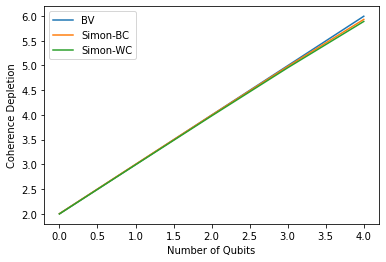

In [176]:
plt.plot(bvDepletions['base'], label='BV')
plt.plot(simonDepletions['BC']['base'], label='Simon-BC')
plt.plot(simonDepletions['WC']['base'],label='Simon-WC')

plt.xlabel('Number of Qubits')
plt.ylabel('Coherence Depletion')
plt.legend()

This plot is a little hard to read, so let's try showing the average coherence depletion per layer of depth to magnify the efficiency.

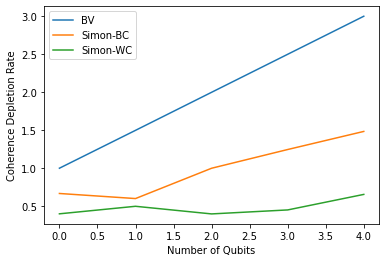

In [177]:
plt.plot(bvDepletions['rate'], label='BV')
plt.plot(simonDepletions['BC']['rate'], label='Simon-BC')
plt.plot(simonDepletions['WC']['rate'],label='Simon-WC')

plt.xlabel('Number of Qubits')
plt.ylabel('Coherence Depletion Rate')
plt.legend()

Now we can clearly see the performance. An interesting question is whether coherence is tied to algorithmic efficiency, potentially some kind of coherence minimization problem over the solution space given by the problem structure. Especially as most quantum algorithms start with at least some register in the maximally coherence state.

##### Grover Search

As a final example, we look at the Grover search algorithm. Very well known for giving an optimal quadratic query speed up over classical unstructured search algorithms, we can see how the coherence behaves. We'll use the implemetation from [4] to generate the output state of an Exactly 1 3-SAT problem.

In [191]:
n = 3

grover = generateGroverCircuit(n)

# Generate the state tomography circuits.
qst_qc = state_tomography_circuits(grover,grover.qubits[0:3])
job = qiskit.execute(qst_qc, Aer.get_backend('qasm_simulator'), shots=10000)

tomo_qc = StateTomographyFitter(job.result(), qst_qc)
test = tomo_qc.fit()

depletion = n - C_r(test)

In [192]:
print([depletion,simonDepletions['WC']['base'][1],simonDepletions['BC']['base'][1],bvDepletions['base'][1]])

[2.562724121735465, 2.9885818537808313, 2.998474270355049, 2.9935866202998236]


From this we see that our coherence depletion for Grover is a bit lower than for Bernstein-Vazirani or Simon's with the same initial coherence. We can assume the depletion rate is abysmal for it as it is a deep circuit. However, using the depletion rate, and maybe looking at coherence drop per depth from the full superposition state for larger systems instead of effective T2, calculating coherence could be useful in benchmarking tasks or searching for an optimal compiled circuit. This way, apples to apples comparisons are being made.

Another avenue to explore is the effects of coherence on entangling operations and vice versa in quantum algorithms, as entanglement has a bit oldre and richer theoretical development. One final thought is that more efficient ways of computing these functions would be needed, perhaps through semidefinite approximation to get around matrix logarithms, using coherence measures linear in the state, or simply more efficient methods of tomography.

# References

[1] A. Streltsov, G. Adesso, M. Plenio. Quantum Coherence as a Resource (https://arxiv.org/abs/1609.02439)

[2] (https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/bernstein_vazirani.ipynb)

[3] (https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/simon_algorithm.ipynb)

[4] (https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/grover_algorithm.ipynb)